In [ ]:
!pip install GPUtil
import os,sys,humanize,psutil,GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=c3225511015aa9cc9f01766cef7d7c08cfefe0c2fa521d8e9efa283e5825dbfa
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [ ]:
def mem_report():
  print("CPU RAM Free:"+humanize.naturalsize(psutil.virtual_memory().available))
mem_report()

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

CPU RAM Free:26.4 GB
Fri Dec  4 14:17:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                   

In [ ]:
import numpy as np
import pandas as pd
import json
import os
import sys
import gzip
import csv
import time
import unicodedata
import re 
import string
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, precision_recall_fscore_support,classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from numpy.linalg import norm

# Unzip the json.gz data file

In [ ]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield json.loads(l)

def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1
        if i%100000 == 0:
            print(i)
    return pd.DataFrame.from_dict(df, orient='index') 
df1 = getDF('Tools_and_Home_Improvement_5.json.gz')

In [ ]:
df1.shape
df1.columns
df.to_csv('Video_Games.csv',index=False)
df1.to_csv('Tools_And_Home_Improvement.csv',index=False)

In [ ]:
df1_ratings = df1['overall']
df1_ratings.value_counts()

In [ ]:
df1_verified = df1[df1['verified']==True]
df1_verified.shape

In [ ]:
df1_verified = df1_verified[['overall','reviewText']]
df1_verified.shape

In [ ]:
df1_verified.head()
df1_ratings = df1_verified['overall']
df1_ratings.value_counts()

# Clean data and show the counts for each class label

In [ ]:
df1_verified.to_csv('Tools_And_Home_Improvement_cleaned.csv',index=False)
df1_verified = df1_verified.dropna()
df1_verified.shape
df_p = pd.read_csv("Tools_And_Home_Improvement_cleaned.csv")
df_p.columns
df_p['overall'].unique
df_p['overall'].value_counts()

# Group the 5 star ratings as neutral, positive, negative 

In [ ]:
def create_sentiment_col(df):
    '''
    Returns a dataframe with additional column sentiment using the logic,
    0 < Rating < 3 => Negative Sentiment (-1)
    Rating == 3 => Neutral Sentiment (0)
    3 < Rating <= 5 => Positive Sentiment (1)
    Input: Pandas DataFrame with columns ['overall','reviewText']
    Output: Pandas DataFrame with columns ['overall','reviewText','sentiment']
    '''
    sentiment = []
    rows, cols = df.shape
    for idx in range(rows):
        rating = df.loc[idx, 'overall']
        if rating == 3:
            sentiment.append(0)
        elif rating >= 0 and rating < 3:
            sentiment.append(-1)
        else:
            sentiment.append(1)
    df['sentiment'] = sentiment
    return df

df_p1 = create_sentiment_col(df_p)
df_p1.shape

In [ ]:
#Drop the rows with null values and create a new csv file 
df_p1 = df_p1.dropna()
df_p1.to_csv('Tools_And_Home_Improvement_cleaned_SentimentCol.csv',index=False)
df_p2 = pd.read_csv("Tools_And_Home_Improvement_cleaned_SentimentCol.csv")
df_p2.shape

# Create Balanced Classes

In [ ]:
import io
from google.colab import files
#Create a new dataframe with 90,000 entries 30000 entries for each of the three sentiments for model development
def create_model_df(df,num_entries=90000):
    '''
    Returns a dataframe with 1/3 of num_entries belonging to each of the three sentiments(pos,neg,neutral)
    Input: Pandas DataFrame with columns ['overall','reviewText','sentiment'] with original dataset
    Output: Pandas DataFrame with columns ['overall','reviewText','sentiment'] with num_entries rows
    '''
    df_neg = df[df['sentiment']==-1].sample(n=int(num_entries/3), replace=False)
    df_neutral = df[df['sentiment']==0].sample(n=int(num_entries/3), replace=False)
    df_pos = df[df['sentiment']==1].sample(n=int(num_entries/3), replace=False)
    return pd.concat([df_neg,df_neutral,df_pos],axis=0).sample(frac=1).reset_index(drop=True)
'''
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
df_p2 = pd.read_csv(io.BytesIO(uploaded['Tools_And_Home_Improvement_cleaned_SentimentCol.csv']))
'''
df_p2 = pd.read_csv('/home/Tools_And_Home_Improvement_cleaned_SentimentCol.csv')
df_p3 = create_model_df(df_p2)
df_p3.shape

(90000, 3)

# Display the value counts for each Class Label

In [ ]:
df_p3['sentiment'].value_counts()

-1    30000
 1    30000
 0    30000
Name: sentiment, dtype: int64

In [ ]:
df_p3.head(100)

,overall,reviewText,sentiment
0,3.0,Fantastic shipping. No screws or screw holes f...,0
1,1.0,garbage,-1
2,5.0,Perfect.,1
3,5.0,Still having difficulty getting the grout clea...,1
4,5.0,I bought this to replace my 6p tailcap. I init...,1
...,...,...,...
95,2.0,not much else to say other than if you buy a c...,-1
96,1.0,I replaced my Xeon lights in my landscape ligh...,-1
97,2.0,Been buying this exact same model for years. ...,-1
98,3.0,Cheap product but there are NO better alternat...,0


# Establish NLP pipeline on the model dataset

In [ ]:
#Establish NLP pipeline on the model dataset df_p3
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
def clean_text(text):
    '''
    Returns a list of tokens ['token1','token2',...'tokenn'] by:
    parsing,tokenizing,removing stopwords, lemmatizing the text string
    Input: A string of the form 'text text text'
    Output: list of tokens ['token1','token2',...'tokenn']
    ''' 
    text = unicodedata.normalize('NFKD',text).encode('ASCII','ignore').decode('utf8')
    text = text.lower()
    text = text.replace("\n",' ')
    #doc = word_tokenize(text)
    doc = re.split(r" ",text)
    doc = [re.sub("[']",'',word) for word in doc]
    pt = string.punctuation
    doc = [word for word in doc if not word in pt]
    doc = [re.sub(r'[~!@#$%^&*()-_+=/'';:,.\|`]*','',word) for word in doc]
    #doc = [re.sub("['][a-z]*",'',word) for word in doc]
    while '' in doc:
        doc.remove('')
    sw = stopwords.words('english')
    #doc = [token for token in doc if (token == 'does') or (token == 'not') or (token not in sw)]
    doc = [token for token in doc if token not in sw]
    lemmatizer = WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(token) for token in doc]
    #This list of words is informed by the random forest model as those that are common between three classes with high information gain
    randomforest_token_list = ['work', 'one', 'product','light', 'price', 'use', 'quality', 'little','well','even','month']
    doc = [token for token in doc if token not in randomforest_token_list]
    return doc

def ngram_token(doc,n=2):
    '''
    Returns a list of tokens ['token1','token2',...'tokenn'] by:
    Appending n-grams to list of tokens if n > 1
    Input: list of tokens ['token1','token2',...'tokenn'], number of ngrams n
    Output: list of tokens with appended n-grams ['token1','token2',...'tokenn', 'token1-token2',..'tokenn-1-tokenn']
    '''
    ng = list(map(lambda tup: '-'.join(tup),ngrams(doc,n)))
    if n>1:
        return doc+ng
    else:
        return doc

tokens = clean_text("I know Red Andy, and don't number n\nknow 12 pink34 victors does not were eager to do more and more doesn't jumping jacks on the fence; this %$ :) is !@#$%^&*()-_/?\~` because: most strong boxers like Maxwell, victors's buddy threatened to leave!!@#")
print(ngram_token(tokens,2))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['know', 'red', 'andy', 'dont', 'number', 'n', 'know', 'pink', 'victor', 'eager', 'doesnt', 'jumping', 'jack', 'fence', 'strong', 'boxer', 'like', 'maxwell', 'victor', 'buddy', 'threatened', 'leave', 'know-red', 'red-andy', 'andy-dont', 'dont-number', 'number-n', 'n-know', 'know-pink', 'pink-victor', 'victor-eager', 'eager-doesnt', 'doesnt-jumping', 'jumping-jack', 'jack-fence', 'fence-strong', 'strong-boxer', 'boxer-like', 'like-maxwell', 'maxwell-victor', 'victor-buddy', 'buddy-threatened', 'threatened-leave']


# Create the Bag of Words Tokens

In [ ]:
def bow_df(df,num_ngram=1):
    '''
    Takes DataFrame with columns ['overall','reviewText','sentiment'] and adds new column with bag of words
    Input: DataFrame with columns ['overall','reviewText','sentiment'], num_ngram
    Output: DataFrame with columns ['overall','reviewText','sentiment','bow_tokens']
    '''
    bow_list = []
    rows, cols = df.shape
    for idx in range(rows):
        bow_list.append(ngram_token(clean_text(df.loc[idx,'reviewText']),num_ngram))
        if idx%10000 == 0:
            print('Cleaned: ',idx)
    df['bow_tokens'] = bow_list
    return df
df_p4 = bow_df(df_p3,2)
df_p4.shape

Cleaned:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: generator 'ngrams' raised StopIteration


Cleaned:  10000
Cleaned:  20000
Cleaned:  30000
Cleaned:  40000
Cleaned:  50000
Cleaned:  60000
Cleaned:  70000
Cleaned:  80000


(90000, 4)

In [ ]:
df_p4.head(100)

,overall,reviewText,sentiment,bow_tokens
0,3.0,Fantastic shipping. No screws or screw holes f...,0,"[fantastic, shipping, screw, screw, hole, moun..."
1,1.0,garbage,-1,[garbage]
2,5.0,Perfect.,1,[perfect]
3,5.0,Still having difficulty getting the grout clea...,1,"[still, difficulty, getting, grout, cleaned, s..."
4,5.0,I bought this to replace my 6p tailcap. I init...,1,"[bought, replace, p, tailcap, initially, bough..."
...,...,...,...,...
95,2.0,not much else to say other than if you buy a c...,-1,"[much, else, say, buy, chamberlain, garage, do..."
96,1.0,I replaced my Xeon lights in my landscape ligh...,-1,"[replaced, xeon, landscape, decent, overall, p..."
97,2.0,Been buying this exact same model for years. ...,-1,"[buying, exact, model, year, sold, fit, base, ..."
98,3.0,Cheap product but there are NO better alternat...,0,"[cheap, better, alternative, would, replace, e..."


# Create the Model Train Test Split

In [ ]:
df_p4.tail(80000)
df_p4.to_csv('Tools_And_Home_Improvement_cleaned_bow.csv',index=False)
#Note: Words like does not are treated as stop words, would like to capture this for neutral and negative ratings
df_p5 = pd.read_csv('Tools_And_Home_Improvement_cleaned_bow.csv')
df_p5.shape
#Create Train Test Split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(df_p5['bow_tokens'],df_p5['sentiment'],test_size=0.2,random_state=42) 
print(Train_X.shape,Train_Y.shape)
print(Test_X.shape,Test_Y.shape)

(72000,) (72000,)
(18000,) (18000,)


# Vectorize the train test split

In [ ]:
def vectorize_bow(dataset,Train_X,Test_X):
    '''
    Takes DataFrame with columns ['bow_tokens'], fits vectorizer model, then transforms Train_X, Test_X
    Input: DataFrame with col ['bow_tokens'], Train_X,Test_X
    Output: Vectorized Train_X_Tfidf, Test_X_Tfidf
    '''
    Tfidf_vect = TfidfVectorizer(max_features=50000)
    Tfidf_vect.fit(dataset)
    Train_X_Tfidf = Tfidf_vect.transform(Train_X)
    Test_X_Tfidf = Tfidf_vect.transform(Test_X)
    return Train_X_Tfidf, Test_X_Tfidf

def vectorize_bow_flag(dataset,Train_X,Test_X,mindf=1,maxdf=1.0):
    '''
    Takes DataFrame with columns ['bow_tokens'], fits vectorizer model, then transforms Train_X, Test_X
    Input: DataFrame with col ['bow_tokens'], Train_X,Test_X, min_df,max_df parameters to drop words
    Output: Vectorized Train_X_Tfidf, Test_X_Tfidf
    '''
    Tfidf_vect = TfidfVectorizer(max_features=50000,max_df=maxdf,min_df=mindf)
    Tfidf_vect.fit(dataset)
    Train_X_Tfidf = Tfidf_vect.transform(Train_X)
    Test_X_Tfidf = Tfidf_vect.transform(Test_X)
    return Train_X_Tfidf, Test_X_Tfidf

Train_X_Tfidf, Test_X_Tfidf = vectorize_bow_flag(df_p5['bow_tokens'],Train_X,Test_X,0.00002,0.05)
print('Vectorized Train_X shape:{0}, Vectorized Test_X shape:{1}'.format(Train_X_Tfidf.shape, Test_X_Tfidf.shape))

Vectorized Train_X shape:(72000, 20753), Vectorized Test_X shape:(18000, 20753)


# Find the best number of features parameter for the Random Forest Model

A Random Forest Classifier with max features of: 100, Accuracy: 0.6628888888888889, Precision: [0.75935473 0.51754241 0.71399594], Recall: [0.63994394 0.58608469 0.76744186]
Execution Time:  771.1384139060974
A Random Forest Classifier with max features of: 150, Accuracy: 0.6632777777777777, Precision: [0.76800266 0.50815352 0.71602434], Recall: [0.64371341 0.58572242 0.76200756]
Execution Time:  742.8230361938477
A Random Forest Classifier with max features of: 200, Accuracy: 0.6636666666666666, Precision: [0.77016464 0.50683578 0.71636241], Recall: [0.64525568 0.58409263 0.76291629]
Execution Time:  773.0449385643005
A Random Forest Classifier with max features of: 250, Accuracy: 0.6635, Precision: [0.76700482 0.5051886  0.72075727], Recall: [0.64648164 0.58452449 0.75885389]
Execution Time:  760.9970619678497
A Random Forest Classifier with max features of: 300, Accuracy: 0.6688888888888889, Precision: [0.77099617 0.5173777  0.72058824], Recall: [0.65030159 0.59533738 0.76193029]
Ex

Text(0.5, 1.0, 'Random Forest: niter = 100, ngram = 2')

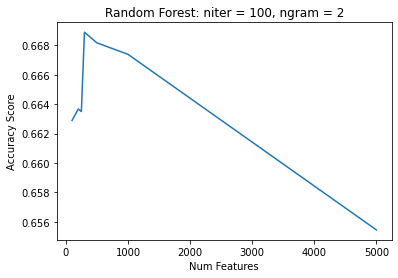

In [ ]:
#Fit RandomForest Model using Train_X_Tfidf,Train_Y and Evaluate Performance using Test_X_Tfidf,Test_Y
#Num estimators 100
features = [100,150,200,250,300,500,1000,5000]
scores = []
for f in features:
    second = time.time()
    rf_model = RandomForestClassifier(n_estimators=100,max_features=f)
    rf_model.fit(Train_X_Tfidf,Train_Y)
    Y_rf_predicted = rf_model.predict(Test_X_Tfidf)
    a,b,c,d = precision_recall_fscore_support(Y_rf_predicted,Test_Y)
    score = accuracy_score(Y_rf_predicted,Test_Y)
    print('A Random Forest Classifier with max features of: {0}, Accuracy: {1}, Precision: {2}, Recall: {3}'
          .format(f,score,a,b))
    scores.append(score)
    print('Execution Time: ',time.time()-second)
    
    
fig, ax = plt.subplots()
ax.plot(features, scores)
ax.set_xlabel('Num Features')
ax.set_ylabel('Accuracy Score')
ax.set_title('Random Forest: num_estimators = 100, ngram = 2')

# We notice that the performance increment is negligible with over 200 iterations for the Random Forest Model

A Random Forest Classifier with num_estimators of: 150, Accuracy: 0.6651111111111111, Precision: [0.76500915 0.51128315 0.7214334 ], Recall: [0.64597669 0.58910609 0.76078431]
Execution Time:  1144.7314894199371
A Random Forest Classifier with num_estimators of: 200, Accuracy: 0.6700555555555555, Precision: [0.77482122 0.51013013 0.72768763], Recall: [0.65124406 0.5970696  0.76073511]
Execution Time:  1542.4623091220856
A Random Forest Classifier with num_estimators of: 300, Accuracy: 0.6753888888888889, Precision: [0.77581906 0.52561357 0.72701149], Recall: [0.65834039 0.60116805 0.7672137 ]
Execution Time:  2382.816389799118
A Random Forest Classifier with num_estimators of: 500, Accuracy: 0.6726111111111112, Precision: [0.77299185 0.5239664  0.72312373], Recall: [0.6571469  0.59725873 0.76379218]
Execution Time:  4076.5163111686707
A Random Forest Classifier with num_estimators of: 1000, Accuracy: 0.6746666666666666, Precision: [0.77482122 0.52577829 0.72565923], Recall: [0.65944798

ValueError: ignored

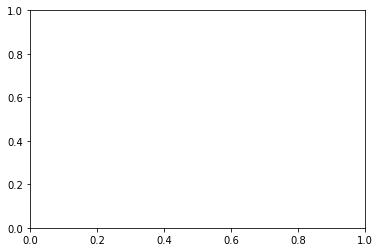

In [ ]:
#Fit RandomForest Model using Train_X_Tfidf,Train_Y and Evaluate Performance using Test_X_Tfidf,Test_Y
#Num Features 300
num_estimators = [150,200,300,500,1000]
scores = []
for est in num_estimators:
    second = time.time()
    rf_model = RandomForestClassifier(n_estimators=est,max_features=300)
    rf_model.fit(Train_X_Tfidf,Train_Y)
    Y_rf_predicted = rf_model.predict(Test_X_Tfidf)
    a,b,c,d = precision_recall_fscore_support(Y_rf_predicted,Test_Y)
    score = accuracy_score(Y_rf_predicted,Test_Y)
    print('A Random Forest Classifier with num_estimators of: {0}, Accuracy: {1}, Precision: {2}, Recall: {3}'
          .format(est,score,a,b))
    scores.append(score)
    print('Execution Time: ',time.time()-second)
    
    
fig, ax = plt.subplots()
ax.plot(features, scores)
ax.set_xlabel('Num Estimators')
ax.set_ylabel('Accuracy Score')
ax.set_title('Random Forest: num features = 300, ngram = 2')

# Find the best number of features parameter for the Random Forest Model for 200 estimators

Vectorized Train_X shape:(72000, 20756), Vectorized Test_X shape:(18000, 20756)
A Random Forest Classifier with max features of: 200, Accuracy: 0.6686111111111112, Precision: [0.75276197 0.52894607 0.72631226], Recall: [0.64537887 0.59290072 0.77022941]
Execution Time:  924.7372608184814
Vectorized Train_X shape:(72000, 20756), Vectorized Test_X shape:(18000, 20756)
A Random Forest Classifier with max features of: 250, Accuracy: 0.6701111111111111, Precision: [0.75175762 0.53257463 0.72815697], Recall: [0.65039826 0.59487841 0.76619022]
Execution Time:  954.6319336891174
Vectorized Train_X shape:(72000, 20756), Vectorized Test_X shape:(18000, 20756)
A Random Forest Classifier with max features of: 300, Accuracy: 0.6679444444444445, Precision: [0.7499163  0.53092528 0.72513835], Recall: [0.65239551 0.58923668 0.76261023]
Execution Time:  1009.2916834354401
Vectorized Train_X shape:(72000, 20756), Vectorized Test_X shape:(18000, 20756)
A Random Forest Classifier with max features of: 350

Text(0.5, 1.0, 'Random Forest: min_df= 0.00002 num_estimators = 200, ngram = 2')

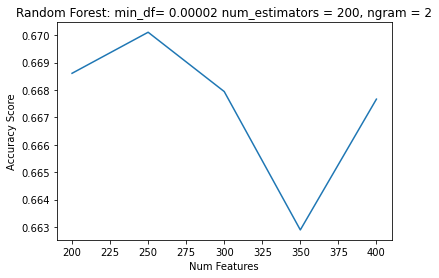

In [ ]:
#Fit RandomForest Model using Train_X_Tfidf,Train_Y and Evaluate Performance using Test_X_Tfidf,Test_Y
#Num estimators 100
features = [200,250,300,350,400]
scores = []
for f in features:
    second = time.time()
    Train_X_Tfidf, Test_X_Tfidf = vectorize_bow_flag(df_p5['bow_tokens'],Train_X,Test_X,0.00002,1.0)
    print('Vectorized Train_X shape:{0}, Vectorized Test_X shape:{1}'.format(Train_X_Tfidf.shape, Test_X_Tfidf.shape))
    rf_model = RandomForestClassifier(n_estimators=200,max_features=f)
    rf_model.fit(Train_X_Tfidf,Train_Y)
    Y_rf_predicted = rf_model.predict(Test_X_Tfidf)
    a,b,c,d = precision_recall_fscore_support(Y_rf_predicted,Test_Y)
    score = accuracy_score(Y_rf_predicted,Test_Y)
    print('A Random Forest Classifier with max features of: {0}, Accuracy: {1}, Precision: {2}, Recall: {3}'
          .format(f,score,a,b))
    scores.append(score)
    print('Execution Time: ',time.time()-second)
    
fig, ax = plt.subplots()
ax.plot(features, scores)
ax.set_xlabel('Num Features')
ax.set_ylabel('Accuracy Score')
ax.set_title('Random Forest: min_df= 0.00002 num_estimators = 200, ngram = 2')

# Vary the max document frequency parameter in the TFIDF vectorization stage to find the best parameter. This Random Forest model uses the best case parameters of 200 estimators and 250 features

Vectorized Train_X shape:(72000, 20461), Vectorized Test_X shape:(18000, 20461)
A Random Forest Classifier with TFIDF Vectorize min_df of 0.00002, max_df of: 0.01, Accuracy: 0.5433333333333333, Precision: [0.56597904 0.3972741  0.66599428], Recall: [0.56570119 0.48351423 0.56551527], Fscore: [0.56584009 0.43617218 0.61165573], Support: [6111 4883 7006]
Execution Time:  1058.447151184082
Vectorized Train_X shape:(72000, 20855), Vectorized Test_X shape:(18000, 20855)
A Random Forest Classifier with TFIDF Vectorize min_df of 0.00002, max_df of: 0.05, Accuracy: 0.6355, Precision: [0.69499018 0.52767962 0.68213145], Recall: [0.63940352 0.55701599 0.70807887], Fscore: [0.66603907 0.54195109 0.69486301], Support: [6639 5630 5731]
Execution Time:  839.038281917572
Vectorized Train_X shape:(72000, 20896), Vectorized Test_X shape:(18000, 20896)
A Random Forest Classifier with TFIDF Vectorize min_df of 0.00002, max_df of: 0.1, Accuracy: 0.6440555555555556, Precision: [0.71905697 0.52616524 0.6848

Text(0.5, 1.0, 'Random Forest: min_df= 0.00002, num_estimators = 200, max_features = 250, ngram = 2')

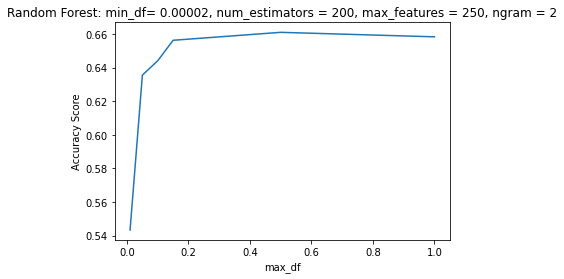

In [ ]:
#Fit RandomForest Model using Train_X_Tfidf,Train_Y and Evaluate Performance using Test_X_Tfidf,Test_Y
#Num estimators 100
maxdf = [0.01,0.05,0.1,0.15,0.5,1.0]
scores = []
for f in maxdf:
    second = time.time()
    Train_X_Tfidf, Test_X_Tfidf = vectorize_bow_flag(df_p5['bow_tokens'],Train_X,Test_X,0.00002,f)
    print('Vectorized Train_X shape:{0}, Vectorized Test_X shape:{1}'.format(Train_X_Tfidf.shape, Test_X_Tfidf.shape))
    rf_model = RandomForestClassifier(n_estimators=200,max_features=250)
    rf_model.fit(Train_X_Tfidf,Train_Y)
    Y_rf_predicted = rf_model.predict(Test_X_Tfidf)
    a,b,c,d = precision_recall_fscore_support(Y_rf_predicted,Test_Y)
    score = accuracy_score(Y_rf_predicted,Test_Y)
    print('A Random Forest Classifier with TFIDF Vectorize min_df of 0.00002, max_df of: {0}, Accuracy: {1}, Precision: {2}, Recall: {3}, Fscore: {4}, Support: {5}'
          .format(f,score,a,b,c,d))
    scores.append(score)
    print('Execution Time: ',time.time()-second)

fig, ax = plt.subplots()
ax.plot(maxdf, scores)
ax.set_xlabel('max_df')
ax.set_ylabel('Accuracy Score')
ax.set_title('Random Forest: min_df= 0.00002, num_estimators = 200, max_features = 250, ngram = 2')

In [ ]:
import tensorflow as tf
import time
tf.test.gpu_device_name()

'/device:GPU:0'

# Compute the Confusion Matrix or the Random Forest Model. This model uses the best case parameters of 200 estimators and 250 features

Vectorized Train_X shape:(72000, 20908), Vectorized Test_X shape:(18000, 20908)
A Random Forest Classifier with TFIDF Vectorize min_df of 0.00002, max_df of: 0.5, Accuracy: 0.6599444444444444, Precision: [0.73542895 0.53424197 0.70801815], Recall: [0.66156112 0.57706289 0.7379117 ], Fscore: [0.6965421  0.55482744 0.72265591], Support: [6790 5502 5708]
Execution Time:  809.1422963142395


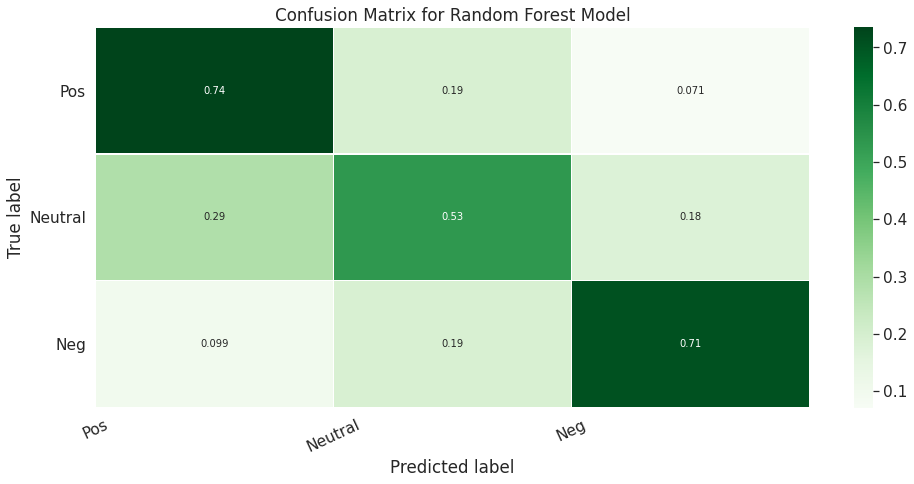

In [ ]:
second = time.time()
f=0.5
Train_X_Tfidf, Test_X_Tfidf = vectorize_bow_flag(df_p5['bow_tokens'],Train_X,Test_X,0.00002,0.5)
print('Vectorized Train_X shape:{0}, Vectorized Test_X shape:{1}'.format(Train_X_Tfidf.shape, Test_X_Tfidf.shape))
rf_model = RandomForestClassifier(n_estimators=200,max_features=250)
rf_model.fit(Train_X_Tfidf,Train_Y)
Y_rf_predicted = rf_model.predict(Test_X_Tfidf)
a,b,c,d = precision_recall_fscore_support(Y_rf_predicted,Test_Y)
score = accuracy_score(Y_rf_predicted,Test_Y)
print('A Random Forest Classifier with TFIDF Vectorize min_df of 0.00002, max_df of: {0}, Accuracy: {1}, Precision: {2}, Recall: {3}, Fscore: {4}, Support: {5}'
      .format(f,score,a,b,c,d))
classification_report(Y_rf_predicted,Test_Y)

print('Execution Time: ',time.time()-second)

# Get and reshape confusion matrix data
matrix = confusion_matrix(Test_Y,Y_rf_predicted)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Pos', 'Neutral', 'Neg']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Store the best case model parameters for the Random Forest Model

In [ ]:
import pickle
filename = 'randomForest_Amazon_Sentiment_Analysis_Model.sav'
pickle.dump(rf_model,open(filename,'wb'))
loaded_model = pickle.load(open(filename,'rb'))
print(loaded_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=250,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


# Evaluate the best case parameters for the Gradient Boost Model.

In [ ]:
#Fit GradientBoosting Model using Train_X_Tfidf,Train_Y and Evaluate Performance using Test_X_Tfidf,Test_Y
#Num estimators 100
from sklearn.ensemble import GradientBoostingClassifier
num_estimators = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 6000, 10000]
scores = []
for f in num_estimators:
    second = time.time()
    Train_X_Tfidf, Test_X_Tfidf = vectorize_bow_flag(df_p5['bow_tokens'],Train_X,Test_X,0.00002,0.5)
    print('Vectorized Train_X shape:{0}, Vectorized Test_X shape:{1}'.format(Train_X_Tfidf.shape, Test_X_Tfidf.shape))
    gb_model = GradientBoostingClassifier(n_estimators=f,max_features='auto',learning_rate=0.01)
    gb_model.fit(Train_X_Tfidf,Train_Y)
    Y_rf_predicted = gb_model.predict(Test_X_Tfidf)
    a,b,c,d = precision_recall_fscore_support(Y_rf_predicted,Test_Y)
    score = accuracy_score(Y_rf_predicted,Test_Y)
    print('A Gradient Boost Classifier with TFIDF Vectorize min_df of 0.00002, num_estimators of: {0}, Accuracy: {1}, Precision: {2}, Recall: {3}, Fscore: {4}, Support: {5}'
          .format(f,score,a,b,c,d))
    scores.append(score)
    print('Execution Time: ',time.time()-second)

fig, ax = plt.subplots()
ax.plot(num_estimators, scores)
ax.set_xlabel('num_esitmators')
ax.set_ylabel('Accuracy Score')
ax.set_title('Gradient Boost: min_df= 0.00002, max_df = 0.5, ngram = 2')

Vectorized Train_X shape:(72000, 20908), Vectorized Test_X shape:(18000, 20908)
A Gradient Boost Classifier with TFIDF Vectorize min_df of 0.00002, num_estimators of: 500, Accuracy: 0.5894444444444444, Precision: [0.69024231 0.5147232  0.56059842], Recall: [0.57391778 0.51953125 0.69974822], Fscore: [0.62672811 0.51711605 0.62249183], Support: [7346 5888 4766]
Execution Time:  1053.4479265213013
Vectorized Train_X shape:(72000, 20908), Vectorized Test_X shape:(18000, 20908)
A Gradient Boost Classifier with TFIDF Vectorize min_df of 0.00002, num_estimators of: 1000, Accuracy: 0.6137222222222222, Precision: [0.68958743 0.53306411 0.61640612], Recall: [0.60814323 0.53504476 0.7116243 ], Fscore: [0.64630965 0.5340526  0.66060169], Support: [6926 5921 5153]
Execution Time:  2067.7775795459747
Vectorized Train_X shape:(72000, 20908), Vectorized Test_X shape:(18000, 20908)
A Gradient Boost Classifier with TFIDF Vectorize min_df of 0.00002, num_estimators of: 1500, Accuracy: 0.628, Precision: 

Text(0.5, 1.0, 'Gradient Boost: min_df= 0.00002, max_df = 0.5, ngram = 2')

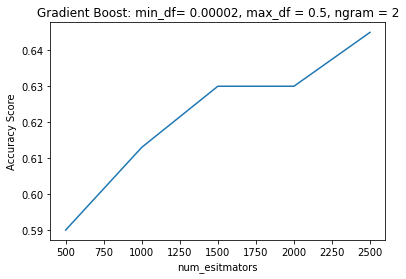

In [ ]:
num_estimators = [500, 1000, 1500, 2000, 2500]
scores = [0.59, 0.613,0.63, 0.63, 0.645]
fig, ax = plt.subplots()
ax.plot(num_estimators, scores)
ax.set_xlabel('num_esitmators')
ax.set_ylabel('Accuracy Score')
ax.set_title('Gradient Boost: min_df= 0.00002, max_df = 0.5, ngram = 2')

# Evaluate the best case parameters for the Gradient Boost Model. This model uses the best case parameters of 3500 estimators and learning rate of 0.01

In [ ]:
#Fit GradientBoosting Model using Train_X_Tfidf,Train_Y and Evaluate Performance using Test_X_Tfidf,Test_Y
#Num estimators 100
from sklearn.ensemble import GradientBoostingClassifier
num_estimators = [3500, 6500, 10000]
scores = []
for f in num_estimators:
    second = time.time()
    Train_X_Tfidf, Test_X_Tfidf = vectorize_bow_flag(df_p5['bow_tokens'],Train_X,Test_X,0.00002,0.5)
    print('Vectorized Train_X shape:{0}, Vectorized Test_X shape:{1}'.format(Train_X_Tfidf.shape, Test_X_Tfidf.shape))
    gb_model = GradientBoostingClassifier(n_estimators=f,max_features='auto',learning_rate=0.01)
    gb_model.fit(Train_X_Tfidf,Train_Y)
    Y_rf_predicted = gb_model.predict(Test_X_Tfidf)
    a,b,c,d = precision_recall_fscore_support(Y_rf_predicted,Test_Y)
    score = accuracy_score(Y_rf_predicted,Test_Y)
    print('A Gradient Boost Classifier with TFIDF Vectorize min_df of 0.00002, num_estimators of: {0}, Accuracy: {1}, Precision: {2}, Recall: {3}, Fscore: {4}, Support: {5}'
          .format(f,score,a,b,c,d))
    scores.append(score)
    print('Execution Time: ',time.time()-second)

fig, ax = plt.subplots()
ax.plot(num_estimators, scores)
ax.set_xlabel('num_esitmators')
ax.set_ylabel('Accuracy Score')
ax.set_title('Gradient Boost: min_df= 0.00002, max_df = 0.5, ngram = 2')

Vectorized Train_X shape:(72000, 20875), Vectorized Test_X shape:(18000, 20875)
A Gradient Boost Classifier with TFIDF Vectorize min_df of 0.00002, num_estimators of: 3500, Accuracy: 0.6436111111111111, Precision: [0.68963233 0.53916119 0.70041494], Recall: [0.63835658 0.56039916 0.73200347], Fscore: [0.66300454 0.54957507 0.7158609 ], Support: [6523 5712 5765]
Execution Time:  8452.08544921875
Vectorized Train_X shape:(72000, 20875), Vectorized Test_X shape:(18000, 20875)


# Compute the Confusion Matrix or the Random Forest Model. This model uses the best case parameters of 200 estimators and 250 features

Vectorized Train_X shape:(72000, 20768), Vectorized Test_X shape:(18000, 20768)
A Random Forest Classifier with TFIDF Vectorize min_df of 0.00002, max_df of: 0.5, Accuracy: 0.6529444444444444, Precision: [0.72396092 0.52507573 0.7079249 ], Recall: [0.65078893 0.56934307 0.73440193], Fscore: [0.68542761 0.54631413 0.7209204 ], Support: [6718 5480 5802]
Execution Time:  908.0218393802643


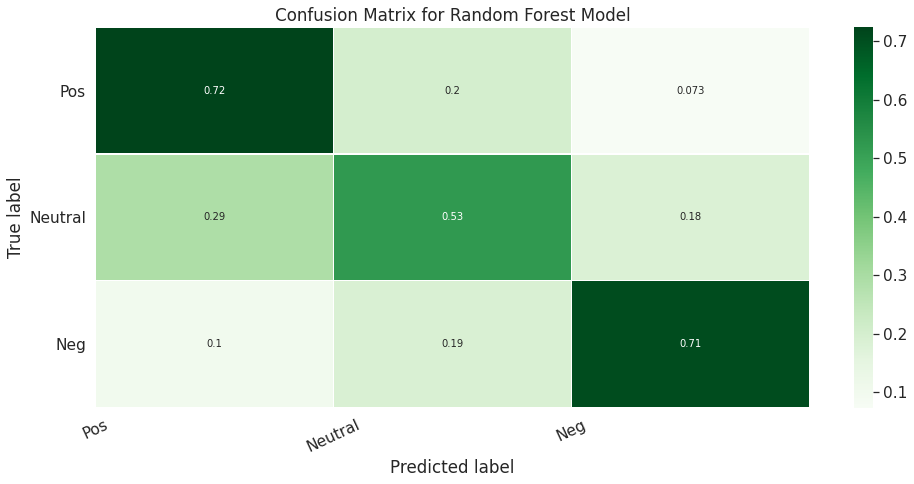

In [ ]:
second = time.time()
f=0.5
Train_X_Tfidf, Test_X_Tfidf = vectorize_bow_flag(df_p5['bow_tokens'],Train_X,Test_X,0.00002,0.5)
print('Vectorized Train_X shape:{0}, Vectorized Test_X shape:{1}'.format(Train_X_Tfidf.shape, Test_X_Tfidf.shape))
rf_model = RandomForestClassifier(n_estimators=200,max_features=250)
rf_model.fit(Train_X_Tfidf,Train_Y)
Y_rf_predicted = rf_model.predict(Test_X_Tfidf)
a,b,c,d = precision_recall_fscore_support(Y_rf_predicted,Test_Y)
score = accuracy_score(Y_rf_predicted,Test_Y)
print('A Random Forest Classifier with TFIDF Vectorize min_df of 0.00002, max_df of: {0}, Accuracy: {1}, Precision: {2}, Recall: {3}, Fscore: {4}, Support: {5}'
      .format(f,score,a,b,c,d))
classification_report(Y_rf_predicted,Test_Y)

print('Execution Time: ',time.time()-second)

# Get and reshape confusion matrix data
matrix = confusion_matrix(Test_Y,Y_rf_predicted)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Pos', 'Neutral', 'Neg']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Compute the Feature Importances For the Random Forest Model. Find the most important features and the sentiment classes that they belong to.


<class 'pandas.core.series.Series'>


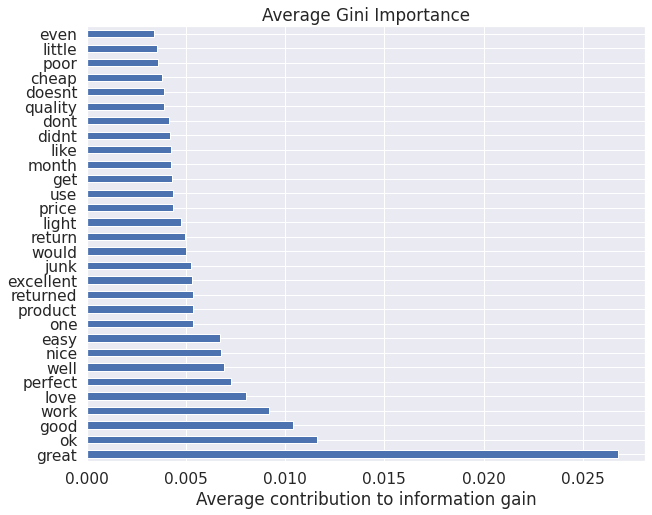

In [ ]:
#Compute The Feature mportance For the Random Forest Model
dataset = df_p5['bow_tokens']
mindf=0.00002
maxdf=0.5
Tfidf_vect = TfidfVectorizer(max_features=50000,max_df=maxdf,min_df=mindf)
Tfidf_vect.fit(dataset)
#print(Tfidf_vect.vocabulary_)
#print(Tfidf_vect.get_feature_names())

# Plot the feature importance
feat_scores = pd.Series(rf_model.feature_importances_,
                           index=Tfidf_vect.get_feature_names())
feat_scores = feat_scores.sort_values(ascending=False)
print(type(feat_scores[4000:4050]))

ax = feat_scores[0:30].plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');


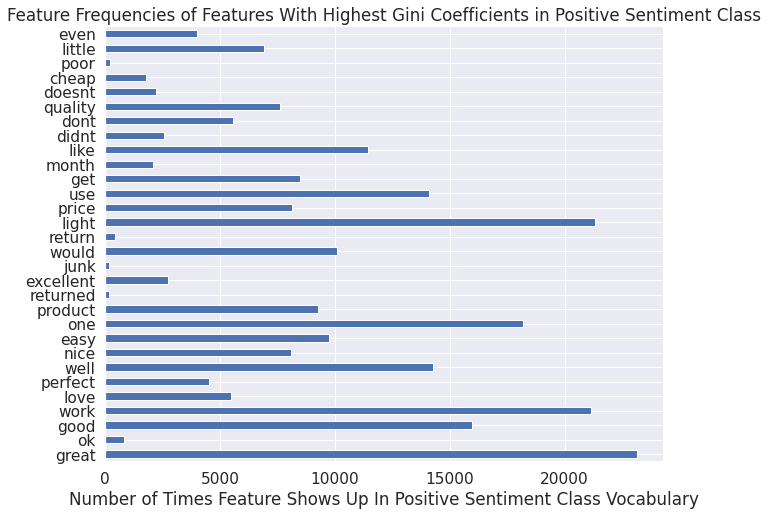

In [ ]:
dataset_pos = df_p5[df_p5['sentiment']==1]['bow_tokens']

Cv_posclass_vect = CountVectorizer()
X_temp = Cv_posclass_vect.fit_transform(dataset_pos)

Cv_posclass_word_frequencies = [X_temp.toarray().sum(axis=0)[Cv_posclass_vect.get_feature_names().index(elem)] for elem in list(feat_scores[0:30].index) if elem in Cv_posclass_vect.get_feature_names()]
#print(Cv_posclass_word_frequencies)

# Plot the feature importance
pos_feat_freq = pd.Series(Cv_posclass_word_frequencies,index=list(feat_scores[0:30].index))


#feat_freq = feat_freq.sort_values(ascending=False)

ax = pos_feat_freq.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Feature Frequencies of Features With Highest Gini Coefficients in Positive Sentiment Class')
ax.set_xlabel('Number of Times Feature Shows Up In Positive Sentiment Class Vocabulary');

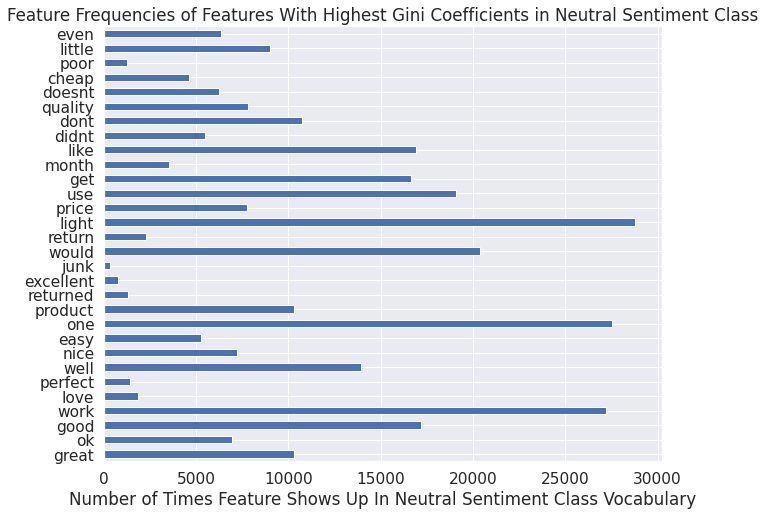

In [ ]:
dataset_neutral = df_p5[df_p5['sentiment']==0]['bow_tokens']

Cv_neutralclass_vect = CountVectorizer()
X_temp = Cv_neutralclass_vect.fit_transform(dataset_neutral)

Cv_neutralclass_word_frequencies = [X_temp.toarray().sum(axis=0)[Cv_neutralclass_vect.get_feature_names().index(elem)] for elem in list(feat_scores[0:30].index) if elem in Cv_neutralclass_vect.get_feature_names()]
#print(Cv_posclass_word_frequencies)

# Plot the feature importance
neutral_feat_freq = pd.Series(Cv_neutralclass_word_frequencies,index=list(feat_scores[0:30].index))


#feat_freq = feat_freq.sort_values(ascending=False)

ax = neutral_feat_freq.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Feature Frequencies of Features With Highest Gini Coefficients in Neutral Sentiment Class')
ax.set_xlabel('Number of Times Feature Shows Up In Neutral Sentiment Class Vocabulary');

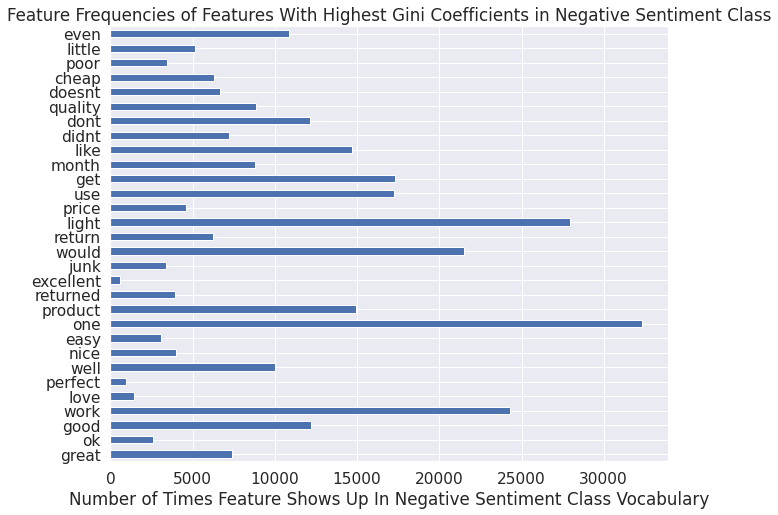

In [ ]:
dataset_negative = df_p5[df_p5['sentiment']==-1]['bow_tokens']

Cv_negativeclass_vect = CountVectorizer()
X_temp = Cv_negativeclass_vect.fit_transform(dataset_negative)

Cv_negativeclass_word_frequencies = [X_temp.toarray().sum(axis=0)[Cv_negativeclass_vect.get_feature_names().index(elem)] for elem in list(feat_scores[0:30].index) if elem in Cv_negativeclass_vect.get_feature_names()]
#print(Cv_posclass_word_frequencies)

# Plot the feature importance
negative_feat_freq = pd.Series(Cv_negativeclass_word_frequencies,index=list(feat_scores[0:30].index))


#feat_freq = feat_freq.sort_values(ascending=False)

ax = negative_feat_freq.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Feature Frequencies of Features With Highest Gini Coefficients in Negative Sentiment Class')
ax.set_xlabel('Number of Times Feature Shows Up In Negative Sentiment Class Vocabulary');

In [ ]:
print('Cosine Similarity Between Pos and Neg Frequencies of Features With Highest Gini Coefficients', np.dot(negative_feat_freq.to_numpy(),pos_feat_freq.to_numpy())/(norm(pos_feat_freq.to_numpy())*norm(negative_feat_freq.to_numpy())))
print('Cosine Similarity Between Neg and Neutral Frequencies of Features With Highest Gini Coefficients', np.dot(neutral_feat_freq.to_numpy(),negative_feat_freq.to_numpy())/(norm(negative_feat_freq.to_numpy())*norm(neutral_feat_freq.to_numpy())))
print('Cosine Similarity Between Pos and Neutral Frequencies of Features With Highest Gini Coefficients', np.dot(neutral_feat_freq.to_numpy(),pos_feat_freq.to_numpy())/(norm(pos_feat_freq.to_numpy())*norm(neutral_feat_freq.to_numpy())))

print('Euclidean Distance Between Pos and Neg Frequencies of Features With Highest Gini Coefficients', norm(pos_feat_freq.to_numpy() - negative_feat_freq.to_numpy()))
print('Euclidean Distance Between Neg and Neutral Frequencies of Features With Highest Gini Coefficients', norm(negative_feat_freq.to_numpy() - neutral_feat_freq.to_numpy()))
print('Euclidean Distance Between Pos and Neutral Frequencies of Features With Highest Gini Coefficients', norm(pos_feat_freq.to_numpy() - neutral_feat_freq.to_numpy()))

Cosine Similarity Between Pos and Neg Frequencies of Features With Highest Gini Coefficients 0.8748181583827623
Cosine Similarity Between Neg and Neutral Frequencies of Features With Highest Gini Coefficients 0.973174123300305
Cosine Similarity Between Pos and Neutral Frequencies of Features With Highest Gini Coefficients 0.9306714091326925
Euclidean Distance Between Pos and Neg Frequencies of Features With Highest Gini Coefficients 34302.68298544591
Euclidean Distance Between Neg and Neutral Frequencies of Features With Highest Gini Coefficients 16302.829386336594
Euclidean Distance Between Pos and Neutral Frequencies of Features With Highest Gini Coefficients 27121.81347181637


In [ ]:
#Potential words to drop: work, one, product,light, price, use, quality, little

In [ ]:
df_p5.columns
#df_p5['bow_tokens'].head(10)

Index(['overall', 'reviewText', 'sentiment', 'bow_tokens'], dtype='object')

In [ ]:
print(df_p5[df_p5['sentiment']==0].loc[5,'reviewText'])
print(df_p5[df_p5['sentiment']==0].loc[5,'bow_tokens'])
print(df_p5[df_p5['sentiment']==1].loc[1,'reviewText'])
print(df_p5[df_p5['sentiment']==1].loc[1,'bow_tokens'])
print('\n')
print(df_p5[df_p5['sentiment']==0].loc[6,'reviewText'])
print(df_p5[df_p5['sentiment']==0].loc[6,'bow_tokens'])
print(df_p5[df_p5['sentiment']==1].loc[111,'reviewText'])
print(df_p5[df_p5['sentiment']==1].loc[111,'bow_tokens'])
print('\n')
print(df_p5[df_p5['sentiment']==0].loc[17,'reviewText'])
print(df_p5[df_p5['sentiment']==0].loc[17,'bow_tokens'])
print('\n')
print(df_p5[df_p5['sentiment']==0].loc[1700,'reviewText'])
print(df_p5[df_p5['sentiment']==0].loc[1700,'bow_tokens'])
print(df_p5[df_p5['sentiment']==-1].loc[43,'reviewText'])
print(df_p5[df_p5['sentiment']==-1].loc[43,'bow_tokens'])
print('\n')
print(df_p5[df_p5['sentiment']==0].loc[18,'reviewText'])
print(df_p5[df_p5['sentiment']==0].loc[18,'bow_tokens'])
print(df_p5[df_p5['sentiment']==-1].loc[43,'reviewText'])
print(df_p5[df_p5['sentiment']==-1].loc[43,'bow_tokens'])

What a handy little item to add to our survival kit! I would recommend!
['handy', 'little', 'item', 'add', 'survival', 'kit', 'would', 'recommend', 'handy-little', 'little-item', 'item-add', 'add-survival', 'survival-kit', 'kit-would', 'would-recommend']
Stanley 15-085 15-Inch 9 point heavy duty saw. Nice saw. Size is easy to use and store. She says it cuts perfect.
['stanley', 'inch', 'point', 'heavy', 'duty', 'saw', 'nice', 'saw', 'size', 'easy', 'use', 'store', 'say', 'cut', 'perfect', 'stanley-inch', 'inch-point', 'point-heavy', 'heavy-duty', 'duty-saw', 'saw-nice', 'nice-saw', 'saw-size', 'size-easy', 'easy-use', 'use-store', 'store-say', 'say-cut', 'cut-perfect']


nice looking, kinda light weight, chrome plastic, but that's what it is.
['nice', 'looking', 'kinda', 'light', 'weight', 'chrome', 'plastic', 'thats', 'nice-looking', 'looking-kinda', 'kinda-light', 'light-weight', 'weight-chrome', 'chrome-plastic', 'plastic-thats']
Shop around for welding wire.  For me, this is the be

Vectorized Train_X shape:(72000, 20795), Vectorized Test_X shape:(18000, 20795)
A Random Forest Classifier with TFIDF Vectorize min_df of 0.00002, max_df of: 0.5, Accuracy: 0.6484444444444445, Precision: [0.71569447 0.51040107 0.71954061], Recall: [0.63128409 0.57509844 0.73470428], Fscore: [0.67084443 0.54082172 0.72704339], Support: [6783 5333 5884]
Execution Time:  904.1910717487335


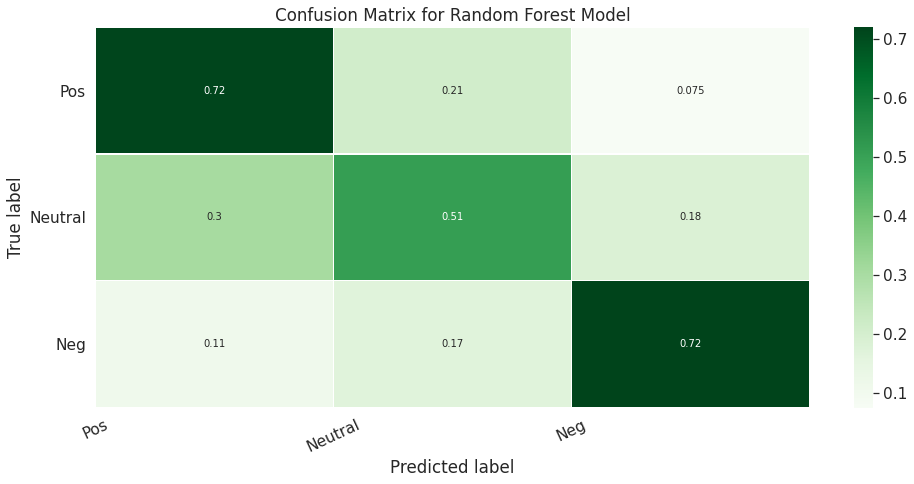

In [ ]:
second = time.time()
f=0.5
Train_X_Tfidf, Test_X_Tfidf = vectorize_bow_flag(df_p5['bow_tokens'],Train_X,Test_X,0.00002,0.5)
print('Vectorized Train_X shape:{0}, Vectorized Test_X shape:{1}'.format(Train_X_Tfidf.shape, Test_X_Tfidf.shape))
rf_model = RandomForestClassifier(n_estimators=200,max_features=250)
rf_model.fit(Train_X_Tfidf,Train_Y)
Y_rf_predicted = rf_model.predict(Test_X_Tfidf)
a,b,c,d = precision_recall_fscore_support(Y_rf_predicted,Test_Y)
score = accuracy_score(Y_rf_predicted,Test_Y)
print('A Random Forest Classifier with TFIDF Vectorize min_df of 0.00002, max_df of: {0}, Accuracy: {1}, Precision: {2}, Recall: {3}, Fscore: {4}, Support: {5}'
      .format(f,score,a,b,c,d))
classification_report(Y_rf_predicted,Test_Y)

print('Execution Time: ',time.time()-second)

# Get and reshape confusion matrix data
matrix = confusion_matrix(Test_Y,Y_rf_predicted)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Pos', 'Neutral', 'Neg']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

<class 'pandas.core.series.Series'>


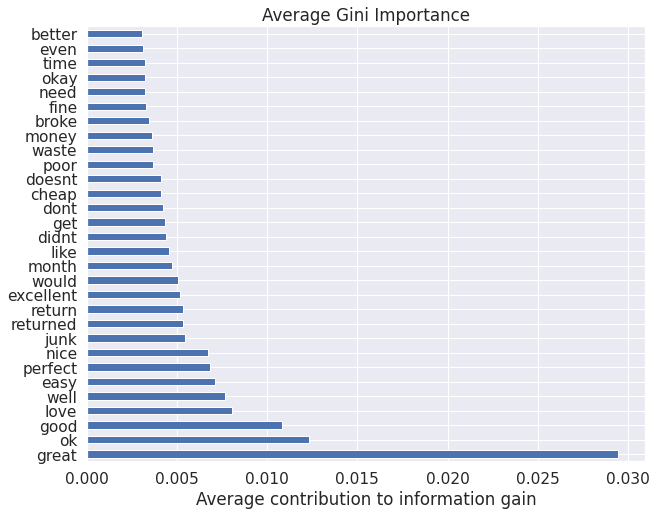

In [ ]:
#Compute The Feature mportance For the Random Forest Model
dataset = df_p5['bow_tokens']
mindf=0.00002
maxdf=0.5
Tfidf_vect = TfidfVectorizer(max_features=50000,max_df=maxdf,min_df=mindf)
Tfidf_vect.fit(dataset)
#print(Tfidf_vect.vocabulary_)
#print(Tfidf_vect.get_feature_names())

# Plot the feature importance
feat_scores = pd.Series(rf_model.feature_importances_,
                           index=Tfidf_vect.get_feature_names())
feat_scores = feat_scores.sort_values(ascending=False)
print(type(feat_scores[4000:4050]))

ax = feat_scores[0:30].plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');